# VQA Model
This is the model with selectable vgg-16 or resnet-50 vision channel and double layer bi-directional LSTM for the language channel. Uses GloVe as word embeddings and 'spacy' for tokenizing.
It is part (the back end) of a splitted model. The front end precalculates the embeddings for the image and question (althought in this case only the image ones are used



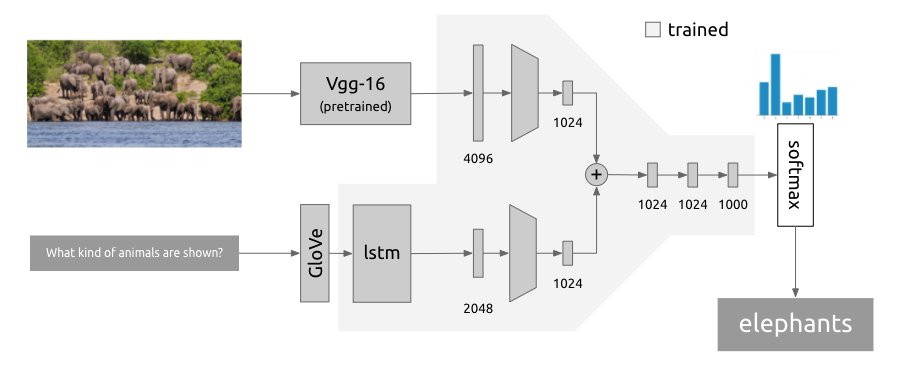

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage import io
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import json
import tqdm
import numpy as np
import time
from datetime import timedelta

VISION = "resnet" # "vgg" or "resnet"

# Data transfer to local disk

Mounting shared Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

sys.path.append('/content/drive/My Drive/aidl/lib')

Mounted at /content/drive


Copy precomputed embeddings from GoogleDrive to the local disk

In [ ]:
if VISION == "vgg":
    ! test ! -f 'vgg_GUSE_embeddings.zip' && cp '/content/drive/My Drive/aidl/vgg_GUSE_embeddings.zip' .
    ! unzip vgg_GUSE_embeddings.zip
else: # resnet
    !cp '/content/drive/My Drive/aidl/'r50_guse_embeddings.zip .
    !unzip r50_guse_embeddings.zip

dataset_root = "/content"

Archive:  r50_guse_embeddings.zip
  inflating: annotation_map.save     
  inflating: image_embeddings.save   
  inflating: question_embeddings.save  
  inflating: annotations.save        
  inflating: metadatas.save          
  inflating: freq.save               


## Language channel

In [ ]:
%%capture
# Install spacy for learnable question embeddings

! pip install spacy
! python -m spacy download en_core_web_sm

import spacy

WORD_EMBEDDING_SIZE = 50
RNN_HIDDEN_SIZE = 512

In [ ]:
# Glove 50 dim embeddings: copy to local

! test ! -f 'glove.6B.50d.txt' && cp '/content/drive/My Drive/aidl/glove/glove.6B.50d.txt' .

# Load glove pretrained embeddings into a dictionary

glove = {}
with open("glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = torch.tensor(list(map(float, values[1:])),dtype=torch.float32)
        glove[word] = vector

print ("{:6,d} GloVe embeddings".format(len(glove)))

400,000 GloVe embeddings


In [ ]:

# Load metadata stored to recover question texts

md = torch.load(os.path.join(dataset_root,'metadatas.save'))

# Create a corpus with all the questions

corpus = [x['question_text'] for x in md]
print ("{:6,d} questions total".format(len(corpus)))

121,512 questions total


In [ ]:
nlp = spacy.load("en_core_web_sm")

def tokenize_en(text):
    return [tok.text.lower() for tok in nlp.tokenizer(text)]

def create_vocabulary(questions):
    vocab = {'<pad>': 0, 'unk': 1}
    idx = len(vocab)
    for q in questions:
        for w in tokenize_en(q):
#            w = w.lower()
            if not(w in vocab.keys()):
                vocab[w] = idx
                idx += 1

    return vocab

def create_embedding_dictionary(corpus):
    global PAD_INDEX

    vocab = create_vocabulary(corpus)
    w_embeddings = torch.zeros(len(vocab),WORD_EMBEDDING_SIZE)
    for w,i in vocab.items():
        try: 
            w_embeddings[i] = glove[w]
        except KeyError:
            w_embeddings[i] = glove['unk']

    PAD_INDEX = vocab['<pad>']
    w_embeddings[PAD_INDEX] = torch.zeros(WORD_EMBEDDING_SIZE)

    return vocab, w_embeddings

In [ ]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class QuestionEmbedding(nn.Module):
    def __init__(self, weights_matrix, hidden_size, num_layers):
        super().__init__()
        
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(w_embeddings, True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)

    def forward(self, input, hidden=None):
        inp, l = input
        e_pck = nn.utils.rnn.pack_padded_sequence(self.embedding(inp),
                                                  l, batch_first=True, enforce_sorted=False)
        e_pck = e_pck.to(device)
        o, (h, c) = self.lstm(e_pck, hidden)
        h = h.transpose(1,0).contiguous().view(min(batch_size,len(inp)),-1)
        
        return h

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [ ]:
def create_sequences(questions, vocabulary):
    seq = []
    seql = []
    
    for q in questions:
        q2t = torch.tensor([vocabulary[w] for w in tokenize_en(q)])
        seq.append(q2t)
        seql.append(len(q2t))
    
    seql = torch.tensor(seql)

    return seq, seql

## Combined Model

Global Parameters

In [ ]:
batch_size = 400
num_epochs = 100
learning_rate = 1.0e-03 / 0.95 ** 3
lmbda = lambda epoch: 0.95 ** (epoch // (num_epochs // 5)) if num_epochs >= 5 else 1.0

!ls '$dataset_root'
device = torch.device('cuda')

annotation_map.save  glove.6B.50d.txt	       r50_guse_embeddings.zip
annotations.save     image_embeddings.save     sample_data
drive		     metadatas.save
freq.save	     question_embeddings.save


Utility functions

In [ ]:
from datetime import datetime
import pytz

# Get a string YYYYMMDDHHMMSS to timestamp the torch.save files

def getTimestamp():
    tz = pytz.timezone("Europe/Madrid")
    
    return datetime.now(tz).strftime("%Y%m%d%H%M%S")

 VQA Model definition

Parameters:
- D_in1 : *image embedding size*
- D_in2 : *question embedding size*
- E     : *Combined embedding size*
- H     : *Classifier hidden layer size*
- D_out : *Classifier output size*

In [ ]:
import torch.nn.functional as F

class VQAm1(nn.Module):
    def __init__(self, D_in1, D_in2, E,  H, D_out):
        super().__init__()

        self.iEmbedding = nn.Sequential(
                              nn.Linear(D_in1, E),
                              nn.ReLU(),
                          )
        
        self.qEmbedding = nn.Sequential(
                              QuestionEmbedding(w_embeddings,RNN_HIDDEN_SIZE,2),
                              nn.Linear(D_in2, E),
                              nn.ReLU(),
                          )
        """ 2 hidden layers classifier 
        self.model = nn.Sequential(
                          nn.Dropout(p=0.5),
                          nn.Linear(E, 2*H),
                          nn.ReLU(),
                          nn.BatchNorm1d(num_features=2*H),
                          nn.Dropout(p=0.5),
                          nn.Linear(2*H, H),
                          nn.ReLU(),
                          nn.BatchNorm1d(num_features=H),
                          nn.Dropout(p=0.5),
                          nn.Linear(H, D_out)
        )
        """
        self.model = nn.Sequential(
                          nn.Dropout(p=0.5),
                          nn.Linear(E, H),
                          nn.ReLU(),
                          nn.BatchNorm1d(num_features=H),
                          nn.Dropout(p=0.5),
                          nn.Linear(H, D_out)
        )


    def forward(self, x1, x2):
# Future test: pass x1 reshaped as initial context for LSTM.
# self.qEmbedding sequential needs to be broken down to support 2 inputs
# h = (torch.reshape(x1,(4,-1,512)), self.qEmbedding.init_hidden(batch_size))
        imageEmbedding = F.normalize(self.iEmbedding(x1))
        questionEmbedding = F.normalize(self.qEmbedding(x2))

        combEmbedding = imageEmbedding * questionEmbedding      # pointwise
#       combEmbedding = torch.cat((imageEmbedding,questionEmbedding), dim=1)

        y_pred = self.model(combEmbedding)

        return y_pred

# Training VQA Model

Dataset and evaluation definition

In [ ]:
# Accuracy calculation prediction(pred) vs ground truth (gtruth)
#   ignoring index value passed in argument ignore

def hits(pred,gtruth,ignore=-1):
    _, y_ = torch.max(pred, 1)
    
    mask = torch.tensor([ignore]*len(pred)).to(device)
    h = ((y_ == gtruth)*(y_ != mask)).sum().item()

    return h, 100 * h / (y_ != mask).sum()  

# Execute an evaluation using test data

def evaluation(model, loader, verbose=False):
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        if verbose:
            batch_iter = tqdm.tqdm(enumerate(loader),
                                   "    ---->",
                                   len(loader),
                                   position=0,
                                   leave=False,unit=" batch")
        else:
            batch_iter = enumerate(loader)

        for batch, (image_embedding, question, annotation) in batch_iter:
            annotation = torch.tensor([a2mfa[e] for e in annotation])
            annotation = annotation.to(device)

            image_embedding = F.normalize(image_embedding)
            image_embedding.to(device)

            seq, seqlen = create_sequences(question,vocab)
            pseq = nn.utils.rnn.pad_sequence(seq,batch_first=True,padding_value=PAD_INDEX)
            pseq = pseq.to(device)

            y_pred = model(image_embedding, (pseq, seqlen))
            loss = criterion(y_pred, annotation)

            h, _ = hits(y_pred,annotation, 999)

            correct += h
            total += annotation.size(0)

    return 100 * correct / total, loss


Define a simple customized Dataset for images (precomputed embeddings), questions (text) and annotations (index)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, questions, answers):

        assert len(questions) == len(images) & len(images) == len(answers), 'Different Lenghts!'

        self.images = images
        self.questions = questions
        self.answers = answers

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return self.images[idx], self.questions[idx], self.answers[idx]

### Load saved embeddings

Preprocessing information is stored in 8 files generated via torch.save:
* 3 files containing training image embeddings, question embeddings and annotations
* 3 files containing validation image embeddings, question embeddings and annotations
* metadatas_train.save contains additional a list of dictionaries with original information about about each triplet (image file name, question in text, ...)
* annotation_map.save contains a dictionary mapping each different answer to an integer

freq.save conatins a list of the 1000 most frequent answers, which is used to re-map the answers when using a reduced (1000 dim) classifier



In [ ]:
#   Load saved embeddings

annotation_map = torch.load(os.path.join(dataset_root,'annotation_map.save'))
image_embeddings = torch.load(os.path.join(dataset_root,'image_embeddings.save'))
question_embeddings = torch.load(os.path.join(dataset_root,'question_embeddings.save'))
annotations = torch.load(os.path.join(dataset_root,'annotations.save'))

#   Reverse annotation_map into a list for index to annotation access

idx2label = ["<>"] * len(annotation_map)
for k,v in annotation_map.items():
  idx2label[v] = k

#   Create list a2mfa to reindex annotations for a fixed size classifier output (1000)

most_freq_answers = torch.load('freq.save')

new_idx = 0
a2mfa = [999] * len(annotation_map)
for k,v in annotation_map.items():
  if k in most_freq_answers:
    a2mfa[v] = new_idx
    new_idx += 1

#   Create list mfa2a for the reverse access

mfa2a = [999] * len(a2mfa)
for k, e in enumerate(a2mfa):
  mfa2a[e] = k

vocab, w_embeddings = create_embedding_dictionary(corpus)

print ("{:6,d} words in vocabulary".format(len(vocab)))

10,288 words in vocabulary


### Model training & validation

In [ ]:

# Dataset split

dataset_size = len(image_embeddings)

dss_train = int(0.75 * dataset_size)
dss_test = int(0.20 * dataset_size)
dss_val = dataset_size - dss_test - dss_train

image_embeddings_train = image_embeddings[:dss_train]
questions_train = corpus[:dss_train]
annotations_train = annotations[:dss_train]
image_embeddings_val = image_embeddings[dss_train:dss_train+dss_val]
questions_val = corpus[dss_train:dss_train+dss_val]
annotations_val = annotations[dss_train:dss_train+dss_val]
image_embeddings_test = image_embeddings[dss_train+dss_val:]
questions_test = corpus[dss_train+dss_val:]
annotations_test = annotations[dss_train+dss_val:]

print ("{:6,d} training".format(dss_train),file=sys.stderr)
print ("{:6,d} validation".format(dss_val),file=sys.stderr)
print ("{:6,d} testing".format(dss_test),file=sys.stderr)

# Create Dataset & Dataloader

train_ds = CustomDataset(image_embeddings_train,questions_train,annotations_train)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)

val_ds = CustomDataset(image_embeddings_val, questions_val, annotations_val)
val_dl = DataLoader(val_ds,batch_size=batch_size,shuffle=False)

test_ds = CustomDataset(image_embeddings_test, questions_test, annotations_test)
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=False)

91,134 training
 6,076 validation
24,302 testing


In [ ]:
start_time = time.time()

# Instantiate VQAmodel
if VISION == "vgg":
    VQAmodel = VQAm1(4096, 2048, 1024, 1024, 1000) # vgg w/1000 classes classifier
else:
    VQAmodel = VQAm1(2048, 2048, 1024, 1024, 1000) # resnet50 w/1000 classes classifier

VQAmodel.to(device)

#w = torch.tensor([sum(ds.annotation_classdist.values())/v for v in ds.annotation_classdist.values()])
#w.true_divide_(sum(w))
#w = w.to(device)

#criterion = torch.nn.CrossEntropyLoss(weight=w)
criterion = torch.nn.CrossEntropyLoss(ignore_index=999)

optimizer = torch.optim.AdamW(VQAmodel.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)

losses = []
accur = []
epoch_e_accur = []
epoch_e_loss = []

for epoch in range(1,num_epochs+1):
    VQAmodel.train()
    epoch_accur = []
    epoch_loss = []

    for batch, (image_embedding, question, annotation) in tqdm.tqdm(enumerate(train_dl),"Epoch {:3d}".format(epoch),len(train_dl),position=0,leave=False,unit=" batch"):
        batch_start_time = time.time()

#   Adjust annotation using only 1000 most frequent answers

        annotation = torch.tensor([a2mfa[e] for e in annotation])

        annotation = annotation.to(device)

        #image_embedding = F.normalize(image_embedding)
        image_embedding = image_embedding.to(device)

        seq, seqlen = create_sequences(question,vocab)
        pseq = nn.utils.rnn.pad_sequence(seq,batch_first=True,padding_value=PAD_INDEX)
        pseq = pseq.to(device)
        y_pred = VQAmodel(image_embedding, (pseq, seqlen))

        loss = criterion(y_pred, annotation)
        
#   Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, accuracy = hits(y_pred, annotation, 999)

        #information on progress

        epoch_accur.append(accuracy)
        epoch_loss.append(float(loss))

    accur.append(sum(epoch_accur).true_divide(len(epoch_accur)))
    losses.append(sum(epoch_loss)/(len(epoch_loss)))
    e_acc, e_loss = evaluation(VQAmodel,val_dl)

    if len(epoch_e_accur) > 0 and e_acc > max(epoch_e_accur):
        # save the model
        torch.save(VQAmodel.state_dict(), 'best.save')

    epoch_e_accur.append(e_acc)
    epoch_e_loss.append(e_loss)

    print("Epoch {:3d}: TRacc: {:3.1f}% TRloss: {:6.4f} EVacc :{:3.1f}% lr: {:5.3e}".format(
        epoch,sum(epoch_accur).true_divide(len(epoch_accur)),sum(epoch_loss)/len(epoch_loss),e_acc,
        scheduler.get_last_lr()[0]),file=sys.stderr)

    scheduler.step()

end_time = time.time()

print ("-"*70,file=sys.stderr)
print ("Total elapsed time.    : {}".format(str(timedelta(seconds=end_time - start_time))),file=sys.stderr)
print("{} samples in {:,.0f} seconds : {:4.1f} samples/sec".format(len(train_ds)*num_epochs,
                                                                   end_time-start_time,len(train_ds)*num_epochs/(end_time-start_time)),file=sys.stderr)
v, i = torch.max(torch.tensor(accur),dim=0)
print ("Max accuracy training  : {:3.1f}% @ epoch {}".format(v,i+1),file=sys.stderr)
v, i = torch.max(torch.tensor(epoch_e_accur),dim=0)
print ("Max accuracy validation: {:3.1f}% @ epoch {}".format(v,i+1),file=sys.stderr)
print ("-"*70,file=sys.stderr)

t_acc, t_loss = evaluation(VQAmodel,test_dl, verbose=True)
print ("Test dataset size     : {:6,d} samples".format(len(test_dl.dataset)),file=sys.stderr)
print ("Accuracy on testing   : {:3.1f}%".format(t_acc),file=sys.stderr)

Epoch   1: TRacc: 27.2% TRloss: 3.1047 EVacc :32.2% lr: 1.166e-03
Epoch   2: TRacc: 31.9% TRloss: 2.4238 EVacc :36.2% lr: 1.166e-03
Epoch   3: TRacc: 34.1% TRloss: 2.1813 EVacc :37.7% lr: 1.166e-03
Epoch   4: TRacc: 36.0% TRloss: 2.0419 EVacc :38.2% lr: 1.166e-03
Epoch   5: TRacc: 37.5% TRloss: 1.9399 EVacc :39.9% lr: 1.166e-03
Epoch   6: TRacc: 39.1% TRloss: 1.8466 EVacc :41.2% lr: 1.166e-03
Epoch   7: TRacc: 40.5% TRloss: 1.7782 EVacc :42.0% lr: 1.166e-03
Epoch   8: TRacc: 41.9% TRloss: 1.7071 EVacc :43.1% lr: 1.166e-03
Epoch   9: TRacc: 43.0% TRloss: 1.6440 EVacc :43.5% lr: 1.166e-03
Epoch  10: TRacc: 44.9% TRloss: 1.5764 EVacc :43.4% lr: 1.166e-03
Epoch  11: TRacc: 46.5% TRloss: 1.5165 EVacc :43.6% lr: 1.166e-03
Epoch  12: TRacc: 48.4% TRloss: 1.4398 EVacc :44.1% lr: 1.166e-03
Epoch  13: TRacc: 50.5% TRloss: 1.3650 EVacc :43.6% lr: 1.166e-03
Epoch  14: TRacc: 52.5% TRloss: 1.2905 EVacc :43.6% lr: 1.166e-03
Epoch  15: TRacc: 54.1% TRloss: 1.2239 EVacc :43.9% lr: 1.166e-03
Epoch  16:

## Plot metrics

In [ ]:
# O p t i o n a l
# Save accuracy information to compare with other models
#       (the YYYYMMDDHHMMSS_info.ext needs to be manually edited describing the
#        experiment) see examples in the directory

ts = getTimestamp()
torch.save(accur,'/content/drive/My Drive/aidl/stats/{}_accur.save'.format(ts))
torch.save(epoch_e_accur,'/content/drive/My Drive/aidl/stats/{}_epoch_e_accur.save'.format(ts))
!touch '/content/drive/My Drive/aidl/stats/'$ts'_info.ext'

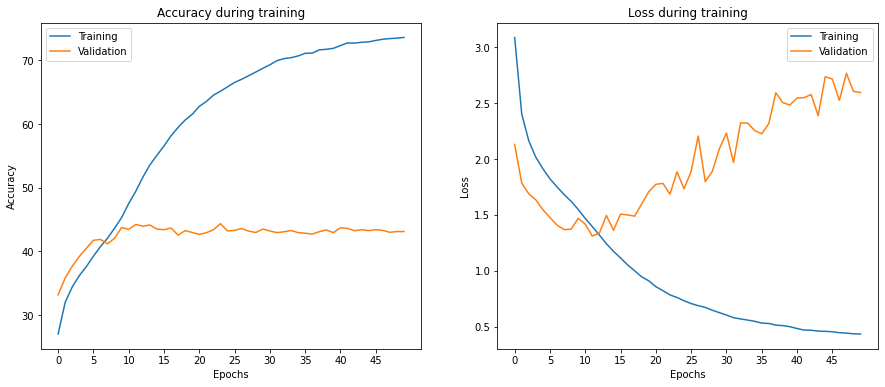

In [ ]:
# plotting
fig, ax = plt.subplots(1,2,figsize=(15, 6))
ax[0].set_title("Accuracy during training")
ax[0].plot(accur, label="Training")
ax[0].plot(epoch_e_accur, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_xticks(range(0,num_epochs,5))
ax[0].set_xticklabels(range(0,num_epochs,5))
ax[0].legend()

ax[1].set_title("Loss during training")
ax[1].plot(losses, label="Training")
ax[1].plot(epoch_e_loss, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_xticks(range(0,num_epochs,5))
ax[1].set_xticklabels(range(0,num_epochs,5))
ax[1].legend()
plt.show()

In [ ]:
# Print info for the log

print (ts)
print (VQAmodel)
print (criterion)
print (optimizer)

20201115170212
VQAm1(
  (iEmbedding): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
  )
  (qEmbedding): Sequential(
    (0): QuestionEmbedding(
      (embedding): Embedding(10288, 50)
      (lstm): LSTM(50, 512, num_layers=2, batch_first=True, bidirectional=True)
    )
    (1): Linear(in_features=2048, out_features=1024, bias=True)
    (2): ReLU()
  )
  (model): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=1024, out_features=1000, bias=True)
  )
)
CrossEntropyLoss()
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0011663507799970843
    lr: 0.0009024999999999999
    weight_decay: 0.01
)
